# Setup

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import copy
import functools
import itertools
import logging
import re
import time
import yaml
from collections import Counter
import pathlib
from pathlib import Path
from pprint import pprint
import sys
from yaml import YAMLObject

import humanize
from matplotlib import pyplot as plt, cm
import numpy as np
from numpy import ndarray
import pandas as pd
from pymicro.file import file_utils
import tensorflow as tf
from numpy.random import RandomState
from progressbar import progressbar as pbar
from enum import Enum
import re
from enum import Enum
from matplotlib import patches
from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import scipy as sp
from numpy import ndarray
from matplotlib import pyplot as plt, patches, cm
from sklearn import metrics as met
from progressbar import progressbar as pbar
from tensorflow.keras import layers
from sklearn import metrics, preprocessing
from sklearn import model_selection

from tomo2seg import modular_unet
from tomo2seg.logger import logger
from tomo2seg import data, viz
from tomo2seg.data import Volume
from tomo2seg.metadata import Metadata
from tomo2seg.volume_sequence import (
    VolumeCropSequence, MetaCrop3DGenerator, VSConstantEverywhere, 
    GTConstantEverywhere, SequentialGridPosition, ET3DConstantEverywhere
)
from tomo2seg import volume_sequence
from tomo2seg.model import Model as Tomo2SegModel
from tomo2seg.data import EstimationVolume
from tomo2seg import AggregationStrategy

# Setup

In [3]:
logger.setLevel(logging.DEBUG)

In [4]:
random_state = 42
random_state = np.random.RandomState(random_state)
runid = int(time.time())

In [5]:
logger.debug(f"{tf.__version__=}")
logger.info(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}\nThis should be 2 on R790-TOMO.")
logger.debug(f"Both here should return 2 devices...\n{tf.config.list_physical_devices('GPU')=}\n{tf.config.list_logical_devices('GPU')=}")

# xla auto-clustering optimization (see: https://www.tensorflow.org/xla#auto-clustering)
# this seems to break the training
tf.config.optimizer.set_jit(False)

# get a distribution strategy to use both gpus (see https://www.tensorflow.org/guide/distributed_training)
strategy = tf.distribute.MirroredStrategy()  
logger.debug(f"{strategy=}")

DEBUG::tomo2seg::{<ipython-input-5-9df7dd5953d5>:<module>:001}::[2020-11-23::07:53:35.764]
tf.__version__='2.2.0'

INFO::tomo2seg::{<ipython-input-5-9df7dd5953d5>:<module>:002}::[2020-11-23::07:53:35.766]
Num GPUs Available: 0
This should be 2 on R790-TOMO.

DEBUG::tomo2seg::{<ipython-input-5-9df7dd5953d5>:<module>:003}::[2020-11-23::07:53:35.805]
Both here should return 2 devices...
tf.config.list_physical_devices('GPU')=[]
tf.config.list_logical_devices('GPU')=[]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
DEBUG::tomo2seg::{<ipython-input-5-9df7dd5953d5>:<module>:011}::[2020-11-23::07:53:35.812]
strategy=<tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f2ceb5cfeb0>



# Options

In [6]:
analyze_crops = False

# Metadata/paths objects

## Model

In [7]:
ls ../data/models | grep unet-2d-small

unet-2d-small.vanilla00.000.1605-971-456.autosaved.hdf5
unet-2d-small.vanilla00.000.1605-972-712/
unet-2d-small.vanilla00.000.1605-972-712.autosaved.hdf5
unet-2d-small.vanilla00.000.1605-982-196/
unet-2d-small.vanilla00.000.1605-982-196.autosaved.hdf5


In [8]:
tomo2seg_model = Tomo2SegModel.build_from_model_name(
    "unet-2d-small.vanilla00.000.1605-982-196"
)
logger.info(f"{tomo2seg_model=}")

INFO::tomo2seg::{<ipython-input-8-cfe47d5c3241>:<module>:004}::[2020-11-23::07:53:36.100]
tomo2seg_model=Model(master_name='unet-2d-small', version='vanilla00', fold=0, runid=1605982196, factory_function=None, factory_kwargs=None)



## Data

In [9]:
from tomo2seg.datasets import (
#     VOLUME_COMPOSITE_V1 as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_REDUCED as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_LABELS_REFINED3 as LABELS_VERSION
)

volume_name, volume_version = VOLUME_NAME_VERSION
labels_version = LABELS_VERSION

logger.info(f"{volume_name=} {volume_version=} {labels_version=}")

INFO::tomo2seg::{<ipython-input-9-cdb1781c8ebd>:<module>:010}::[2020-11-23::07:53:36.164]
volume_name='PA66GF30' volume_version='v1-reduced' labels_version='refined3'



In [10]:
volume = Volume.with_check(
    name=volume_name, version=volume_version
)
logger.info(f"{volume=}")

def _read_raw(path_: Path, volume_: Volume, dims=None): 
    # from pymicro
    return file_utils.HST_read(
        str(path_),  # it doesn't accept paths...
        # pre-loaded kwargs
        autoparse_filename=False,  # the file names are not properly formatted
        data_type=volume.metadata.dtype,
        dims=dims or volume.metadata.dimensions,
        verbose=True,
    )

read_raw = functools.partial(_read_raw, volume_=volume)

DEBUG::tomo2seg::{data.py:with_check:237}::[2020-11-23::07:53:36.239]
vol=Volume(name='PA66GF30', version='v1-reduced', _metadata=None)

ERROR::tomo2seg::{data.py:with_check:255}::[2020-11-23::07:53:36.242]
Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.labels.raw

Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.weights.raw

DEBUG::tomo2seg::{data.py:metadata:194}::[2020-11-23::07:53:36.246]
Loading metadata from `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.metadata.yml`.

INFO::tomo2seg::{<ipython-input-10-9697bd3fb44b>:<module>:004}::[2020-11-23::07:53:36.259]
volume=Volume(name='PA66GF30', version='v1-reduced', _metadata=Volume.Metadata(dimensions=[256, 256, 256], dtype='uint8', labels=[0, 1, 2], labels_names={0: 'matrix', 1: 'fiber', 2: 'porosity'}, set_partitions={'train': {'x_range': [0, 256], 'y_range': [0, 256], 'z_range': [0, 128], 'alias

## Estimation volume

In [11]:
# data_volume = voldata_train
# partition = volume.val_partition
partition = volume.test_partition
runid = 1606072056

volume_and_partition_name = f"{volume.fullname}.partition={partition.alias}"

read_raw_partition = functools.partial(_read_raw, volume_=volume, dims=partition.shape)

logger.debug(f"{partition=} {runid=} {volume_and_partition_name=}")

DEBUG::tomo2seg::{<ipython-input-11-3c21340cedd6>:<module>:010}::[2020-11-23::07:53:36.323]
partition=SetPartition(x_range=(0, 256), y_range=(0, 256), z_range=(192, 256), alias='test') runid=1606072056 volume_and_partition_name='PA66GF30.v1-reduced.partition=test'



In [12]:
estimation_volume = EstimationVolume.from_objects(
    volume=volume, 
    model=tomo2seg_model, 
    set_partition=partition,
    runid=runid,
)
logger.info(f"{estimation_volume=}")

figs_dir = estimation_volume.dir

INFO::tomo2seg::{<ipython-input-12-bafe1e91b086>:<module>:007}::[2020-11-23::07:53:36.381]
estimation_volume=EstimationVolume(volume_fullname='PA66GF30.v1-reduced', model_name='unet-2d-small.vanilla00.000.1605-982-196', runid=1606072056, partition=SetPartition(x_range=(0, 256), y_range=(0, 256), z_range=(192, 256), alias='test'))



# Load from the disk

In [13]:
logger.debug("Loading data from disk.")

DEBUG::tomo2seg::{<ipython-input-13-ded26959866d>:<module>:001}::[2020-11-23::07:53:36.420]
Loading data from disk.



## Data

In [14]:
data_volume = read_raw(volume.data_path)
logger.debug(f"{data_volume.shape=}")

data_volume = partition.get_volume_partition(data_volume)
logger.debug(f"(only {partition.alias=}) {data_volume.shape=}")

data type is uint8
volume size is 256 x 256 x 256
reading volume... from byte 0
DEBUG::tomo2seg::{<ipython-input-14-7e7a825f2d03>:<module>:002}::[2020-11-23::07:53:36.520]
data_volume.shape=(256, 256, 256)

DEBUG::tomo2seg::{<ipython-input-14-7e7a825f2d03>:<module>:005}::[2020-11-23::07:53:36.521]
(only partition.alias='test') data_volume.shape=(256, 256, 64)



## Labels

In [15]:
labels_volume = read_raw(volume.versioned_labels_path(labels_version))
logger.debug(f"{labels_volume.shape=}")

labels_volume = partition.get_volume_partition(labels_volume)
logger.debug(f"(only {partition.alias=}) {labels_volume.shape=}")

data type is uint8
volume size is 256 x 256 x 256
reading volume... from byte 0
DEBUG::tomo2seg::{<ipython-input-15-5b1b50957cf2>:<module>:002}::[2020-11-23::07:53:37.557]
labels_volume.shape=(256, 256, 256)

DEBUG::tomo2seg::{<ipython-input-15-5b1b50957cf2>:<module>:005}::[2020-11-23::07:53:37.558]
(only partition.alias='test') labels_volume.shape=(256, 256, 64)



## Probabilities

In [16]:
probabilities_are_available = False

if estimation_volume.probabilities_path.exists():
    # float16 instead of 64 to save memory
    probas_volume = np.load(estimation_volume.probabilities_path).astype(np.float16)
    logger.debug(f"{probas_volume.shape=}")
    probabilities_are_available = True
    
else:
    logger.info("Probabilities are not available.")

DEBUG::tomo2seg::{<ipython-input-16-5abccb8499c7>:<module>:006}::[2020-11-23::07:53:39.236]
probas_volume.shape=(256, 256, 64, 3)



## Predictions

In [17]:
predictions_volume = read_raw_partition(estimation_volume.predictions_path)
logger.debug(f"{predictions_volume.shape=}")

data type is uint8
volume size is 256 x 256 x 64
reading volume... from byte 0
DEBUG::tomo2seg::{<ipython-input-17-fb06bad75c33>:<module>:002}::[2020-11-23::07:53:40.402]
predictions_volume.shape=(256, 256, 64)



# Class imbalance

In [18]:
labels_idx = volume.metadata.labels
labels_names = [volume.metadata.labels_names[idx] for idx in labels_idx]
n_classes = len(labels_idx)

logger.debug(f"{labels_idx=}\n{labels_names=}\n{n_classes=}")

DEBUG::tomo2seg::{<ipython-input-18-470efc35a83d>:<module>:005}::[2020-11-23::07:53:42.134]
labels_idx=[0, 1, 2]
labels_names=['matrix', 'fiber', 'porosity']
n_classes=3



In [19]:
logger.info("Computing label class imbalance.")
_, labels_counts = np.unique(labels_volume, return_counts=True)

INFO::tomo2seg::{<ipython-input-19-7e3186c17741>:<module>:001}::[2020-11-23::07:53:47.734]
Computing label class imbalance.



INFO::tomo2seg::{viz.py:plot:528}::[2020-11-23::07:53:48.721]
The minimum accuracy is: random_model_accu=79.77%

INFO::tomo2seg::{<ipython-input-20-085ae63c31fe>:<module>:010}::[2020-11-23::07:53:48.722]
Saving figure (figname := display.title + '.png')='PA66GF30.v1-reduced.partition=test.class-imbalance.png'



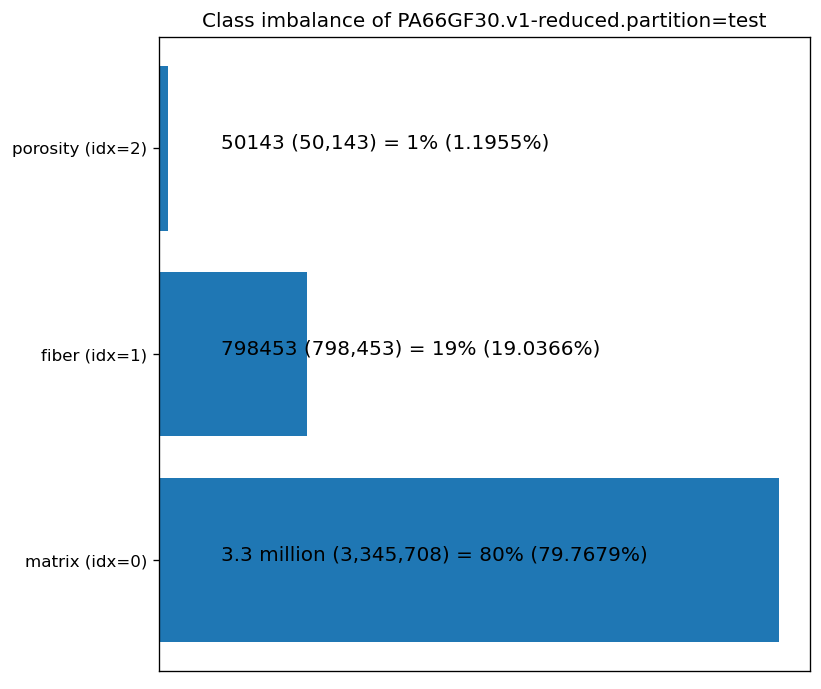

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(sz := 7, sz), dpi=(dpi := 120))

display = viz.ClassImbalanceDisplay(
    volume_name=volume_and_partition_name,
    labels_idx=labels_idx,
    labels_names=labels_names,
    labels_counts=labels_counts,
).plot(ax)

logger.info(f"Saving figure {(figname := display.title + '.png')=}")
display.fig_.savefig(
    fname=figs_dir / figname,
    format="png",
    metadata=display.metadata,
)    

# Value histograms

In [21]:
data_volume_raveled_t = tf.convert_to_tensor(
    value=data_volume.ravel(),
    dtype=tf.int32,
    name=f"{volume.fullname}-data-raveled"
)

## All data

In [22]:
data_hist_t = tf.histogram_fixed_width(
    values=data_volume_raveled_t,
    value_range=tf.constant((hist_range := [0, 255]), dtype=data_volume_raveled_t.dtype),
    nbins=(n_bins := 256),
    dtype=data_volume_raveled_t.dtype,
    name=f"{volume.fullname}.data-histogram"
)
data_hist_t = data_hist_t / tf.math.reduce_sum(data_hist_t)
# todo save these values# 

INFO::tomo2seg::{<ipython-input-23-b1f18ac9ca0e>:<module>:010}::[2020-11-23::07:53:57.481]
Saving figure (figname := display.title + '.png')='PA66GF30.v1-reduced.partition=test.voxel-value-histogram.png'



/home/joaopcbertoldo/projects/tomo2seg/tomo2seg/viz.py:585: UserWarning: FixedFormatter should only be used together with FixedLocator
  axlog.set_yticklabels(


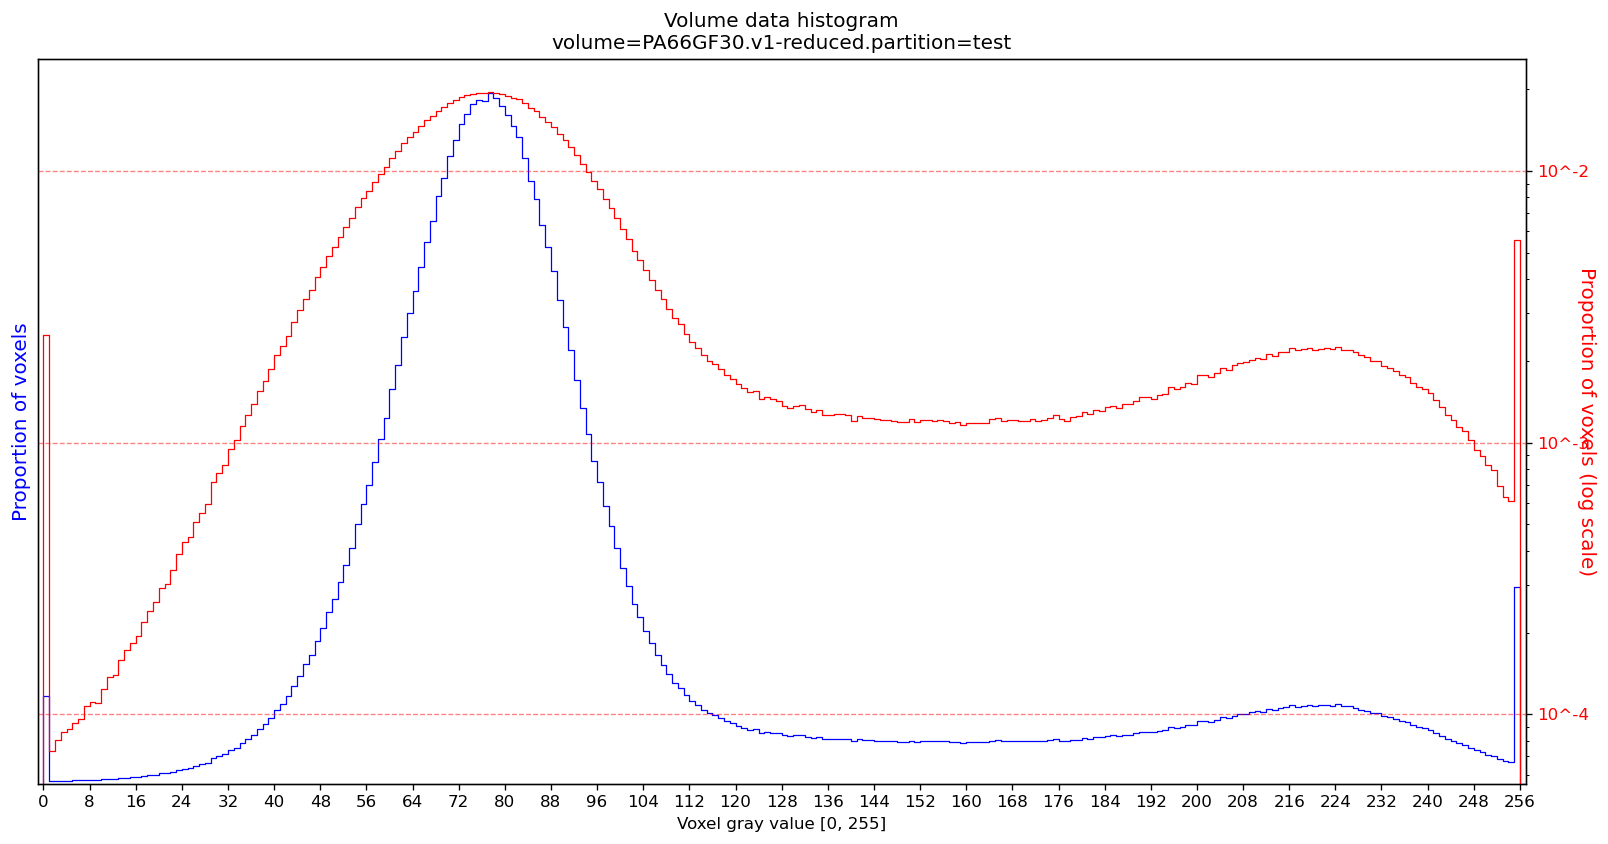

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(2* (sz := 8), sz), dpi=(dpi := 120))

# i want to get the vertical borders to show up
display = viz.VoxelValueHistogramDisplay(
    volume_name=volume_and_partition_name,
    bins=np.linspace(*hist_range, n_bins).astype(int).tolist(),
    values=data_hist_t.numpy().tolist(),
).plot(ax)
 
logger.info(f"Saving figure {(figname := display.title + '.png')=}")
display.fig_.savefig(
    fname=figs_dir / figname,
    format="png",
    metadata=display.metadata,
)    

## Per label

In [24]:
labels_volume_raveled_t = tf.convert_to_tensor(
    labels_volume.ravel(), dtype=tf.int8
)

In [25]:
data_hists_per_label = []
data_hists_per_label_global_prop = []
n_voxels = np.sum(labels_counts)

for label_idx in labels_idx:
    logger.debug(f"Computing histogram for {label_idx=}")
    
    label_data_hist_t = tf.histogram_fixed_width(
        values=data_volume_raveled_t[labels_volume_raveled_t == label_idx],
        value_range=tf.constant(hist_range, dtype=data_volume_raveled_t.dtype),
        nbins=n_bins,
        dtype=data_volume_raveled_t.dtype,
        name=f"{volume.fullname}.data-histogram"
    )
    data_hists_per_label.append(
        (label_data_hist_t / tf.math.reduce_sum(label_data_hist_t)).numpy().tolist()
    )
    data_hists_per_label_global_prop.append(
        (label_data_hist_t.numpy() / n_voxels).tolist()
    )

DEBUG::tomo2seg::{<ipython-input-25-d94bc39a492e>:<module>:006}::[2020-11-23::07:54:01.195]
Computing histogram for label_idx=0

DEBUG::tomo2seg::{<ipython-input-25-d94bc39a492e>:<module>:006}::[2020-11-23::07:54:01.249]
Computing histogram for label_idx=1

DEBUG::tomo2seg::{<ipython-input-25-d94bc39a492e>:<module>:006}::[2020-11-23::07:54:01.267]
Computing histogram for label_idx=2



INFO::tomo2seg::{<ipython-input-33-a125f566f367>:<module>:018}::[2020-11-23::07:55:02.164]
Saving figure (figname := display.title + '.png')='PA66GF30.v1-reduced.partition=test.data-histogram-per-label.png'



/home/joaopcbertoldo/projects/tomo2seg/tomo2seg/viz.py:678: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax_global.set_ybound(lower=0)


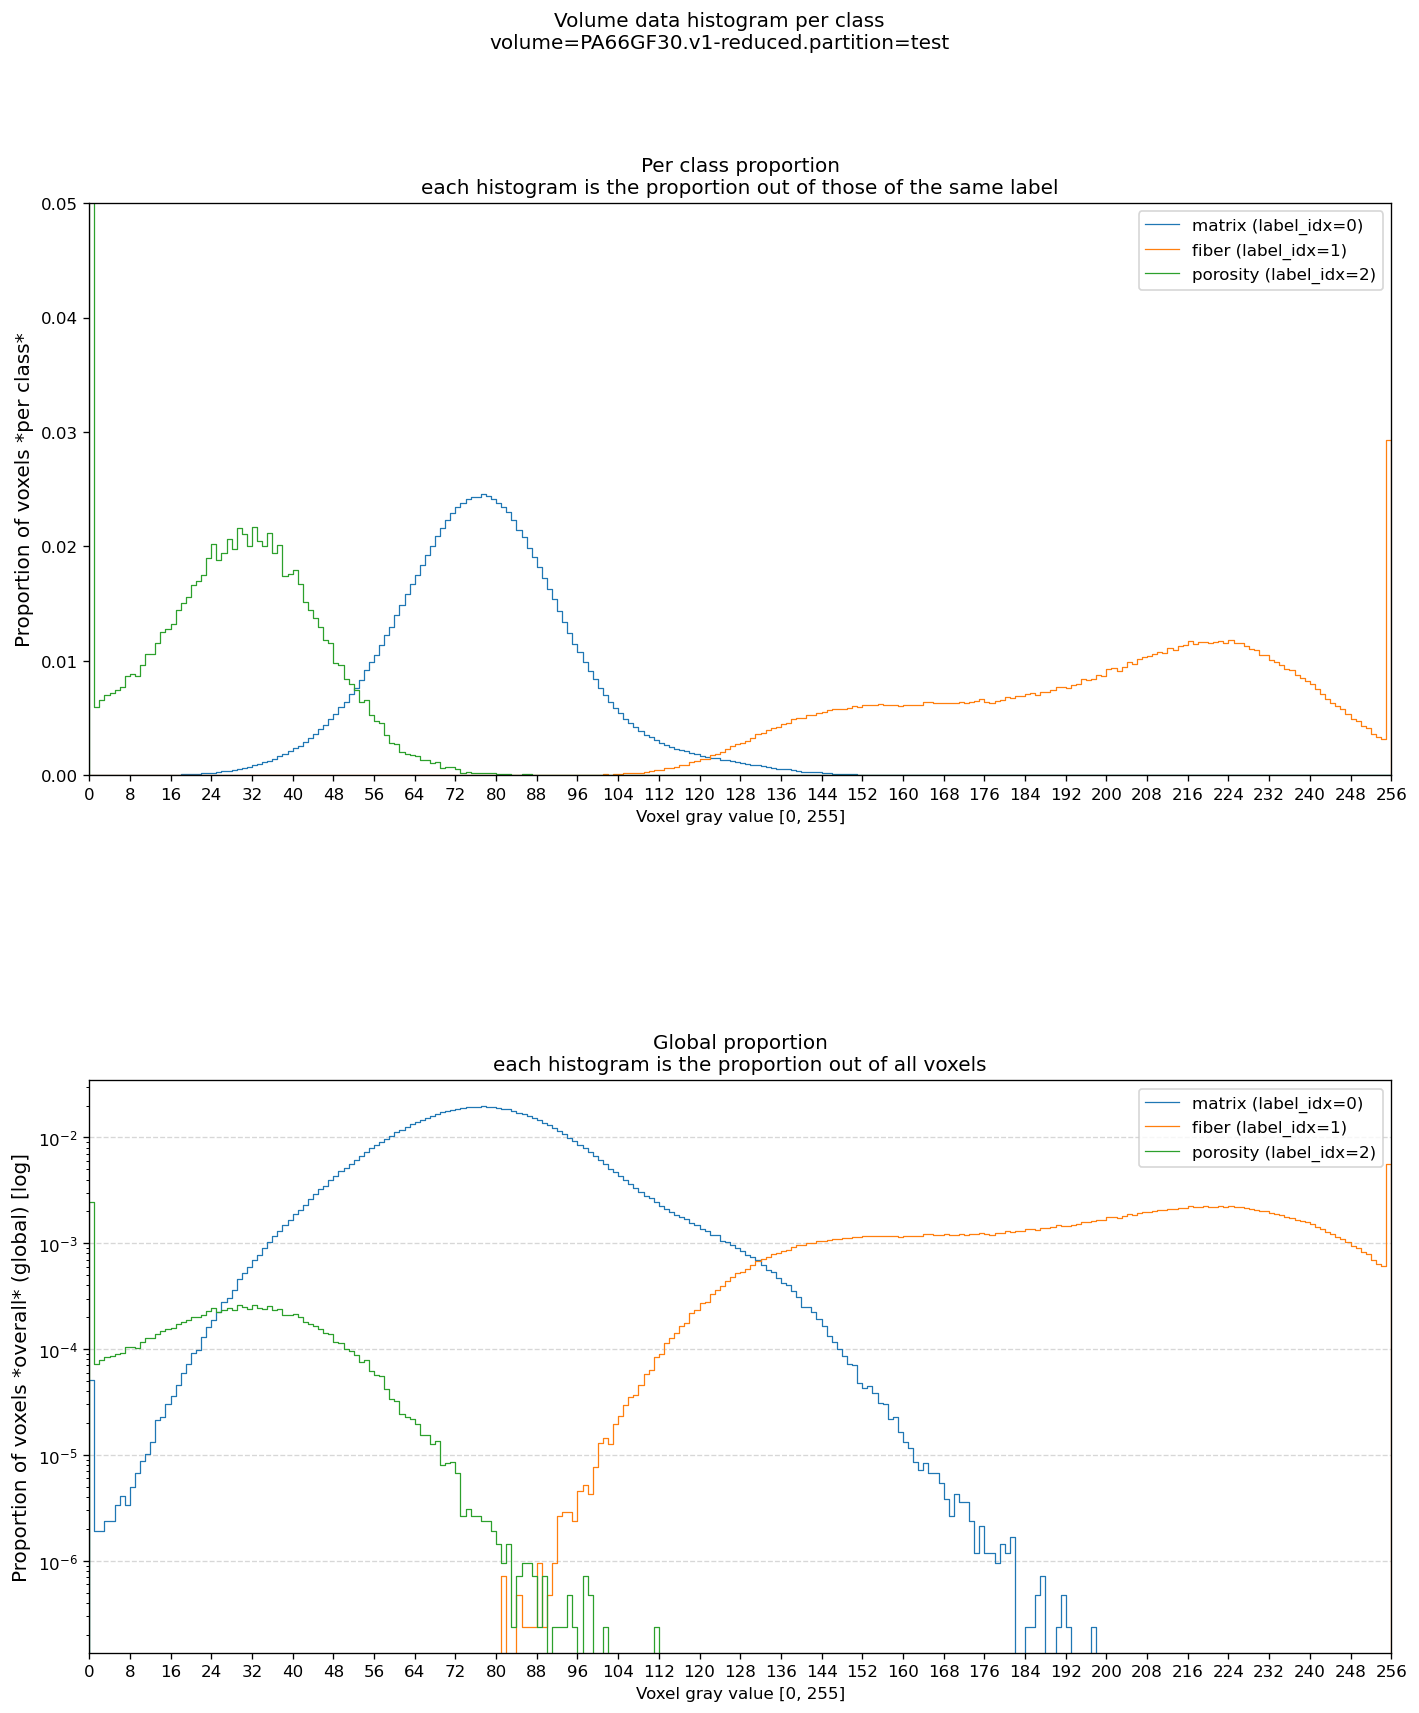

In [33]:
fig, axs = plt.subplots(
    nrows := 2, ncols := 1, figsize=(ncols * 1.75 * (sz := 8), nrows * sz), dpi=(dpi := 120),
    gridspec_kw=dict(hspace=sz/15)
)

bins = np.linspace(*hist_range, n_bins).astype(int).tolist()

display = viz.VoxelValueHistogramPerClassDisplay(
    volume_name=volume_and_partition_name,
    bins=bins,
    values_per_label=data_hists_per_label,
    values_per_label_global_proportion=data_hists_per_label_global_prop,
    labels_idx=labels_idx,
    labels_names=labels_names,
).plot(axs)
axs[0].set_ylim(top=.05)
 
logger.info(f"Saving figure {(figname := display.title + '.png')=}")
display.fig_.savefig(
    fname=figs_dir / figname,
    format="png",
    metadata=display.metadata,
)    

# Per-class predicted probabilities histograms

In [34]:
logger.info("Computing probability histograms per label.")
probas_volume_reshaped = probas_volume.reshape(-1, n_classes)

INFO::tomo2seg::{<ipython-input-34-d04daec5ceae>:<module>:001}::[2020-11-23::07:55:28.239]
Computing probability histograms per label.



In [35]:
histograms = []
bins = np.linspace(0, 1, 101)

for label_idx in labels_idx:
    logger.debug(f"Computing histogram for {label_idx=}")
    
    selector = labels_volume.ravel() == label_idx
    
    label_hists = []
    for class_proba_idx in labels_idx:
        values, _ = np.histogram(
            probas_volume_reshaped[selector, class_proba_idx], bins=bins
        ) 
        label_hists.append(values / values.sum())
        
    histograms.append(label_hists)
    
histograms = np.array(histograms)

DEBUG::tomo2seg::{<ipython-input-35-4993648b602d>:<module>:005}::[2020-11-23::07:55:29.780]
Computing histogram for label_idx=0

DEBUG::tomo2seg::{<ipython-input-35-4993648b602d>:<module>:005}::[2020-11-23::07:55:30.454]
Computing histogram for label_idx=1

DEBUG::tomo2seg::{<ipython-input-35-4993648b602d>:<module>:005}::[2020-11-23::07:55:30.731]
Computing histogram for label_idx=2



In [36]:
logger.info(f"Saving probabilities histograms at `{estimation_volume.probabilities_histograms_path=}`")
np.save(
    estimation_volume.probabilities_histograms_path,
    histograms
)

INFO::tomo2seg::{<ipython-input-36-99c8ff0f8ff0>:<module>:001}::[2020-11-23::07:55:33.084]
Saving probabilities histograms at `estimation_volume.probabilities_histograms_path=PosixPath('/home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.000.1605-982-196.runid=1606-072-056.probabilities-histograms.npy')`



INFO::tomo2seg::{<ipython-input-37-e169019d2e0f>:<module>:001}::[2020-11-23::07:55:39.616]
Saving figure (fig_name := 'class-probabilities-per-label.png')='class-probabilities-per-label.png'

DEBUG::tomo2seg::{<ipython-input-37-e169019d2e0f>:<module>:012}::[2020-11-23::07:55:39.673]
Plotting histograms for label_idx=0

DEBUG::tomo2seg::{<ipython-input-37-e169019d2e0f>:<module>:015}::[2020-11-23::07:55:39.674]
Drawing histogram for probability of class_proba_idx=0

DEBUG::tomo2seg::{<ipython-input-37-e169019d2e0f>:<module>:015}::[2020-11-23::07:55:39.677]
Drawing histogram for probability of class_proba_idx=1

DEBUG::tomo2seg::{<ipython-input-37-e169019d2e0f>:<module>:015}::[2020-11-23::07:55:39.679]
Drawing histogram for probability of class_proba_idx=2

DEBUG::tomo2seg::{<ipython-input-37-e169019d2e0f>:<module>:012}::[2020-11-23::07:55:39.725]
Plotting histograms for label_idx=1

DEBUG::tomo2seg::{<ipython-input-37-e169019d2e0f>:<module>:015}::[2020-11-23::07:55:39.726]
Drawing histog

NameError: name 'figs_common_kwargs' is not defined

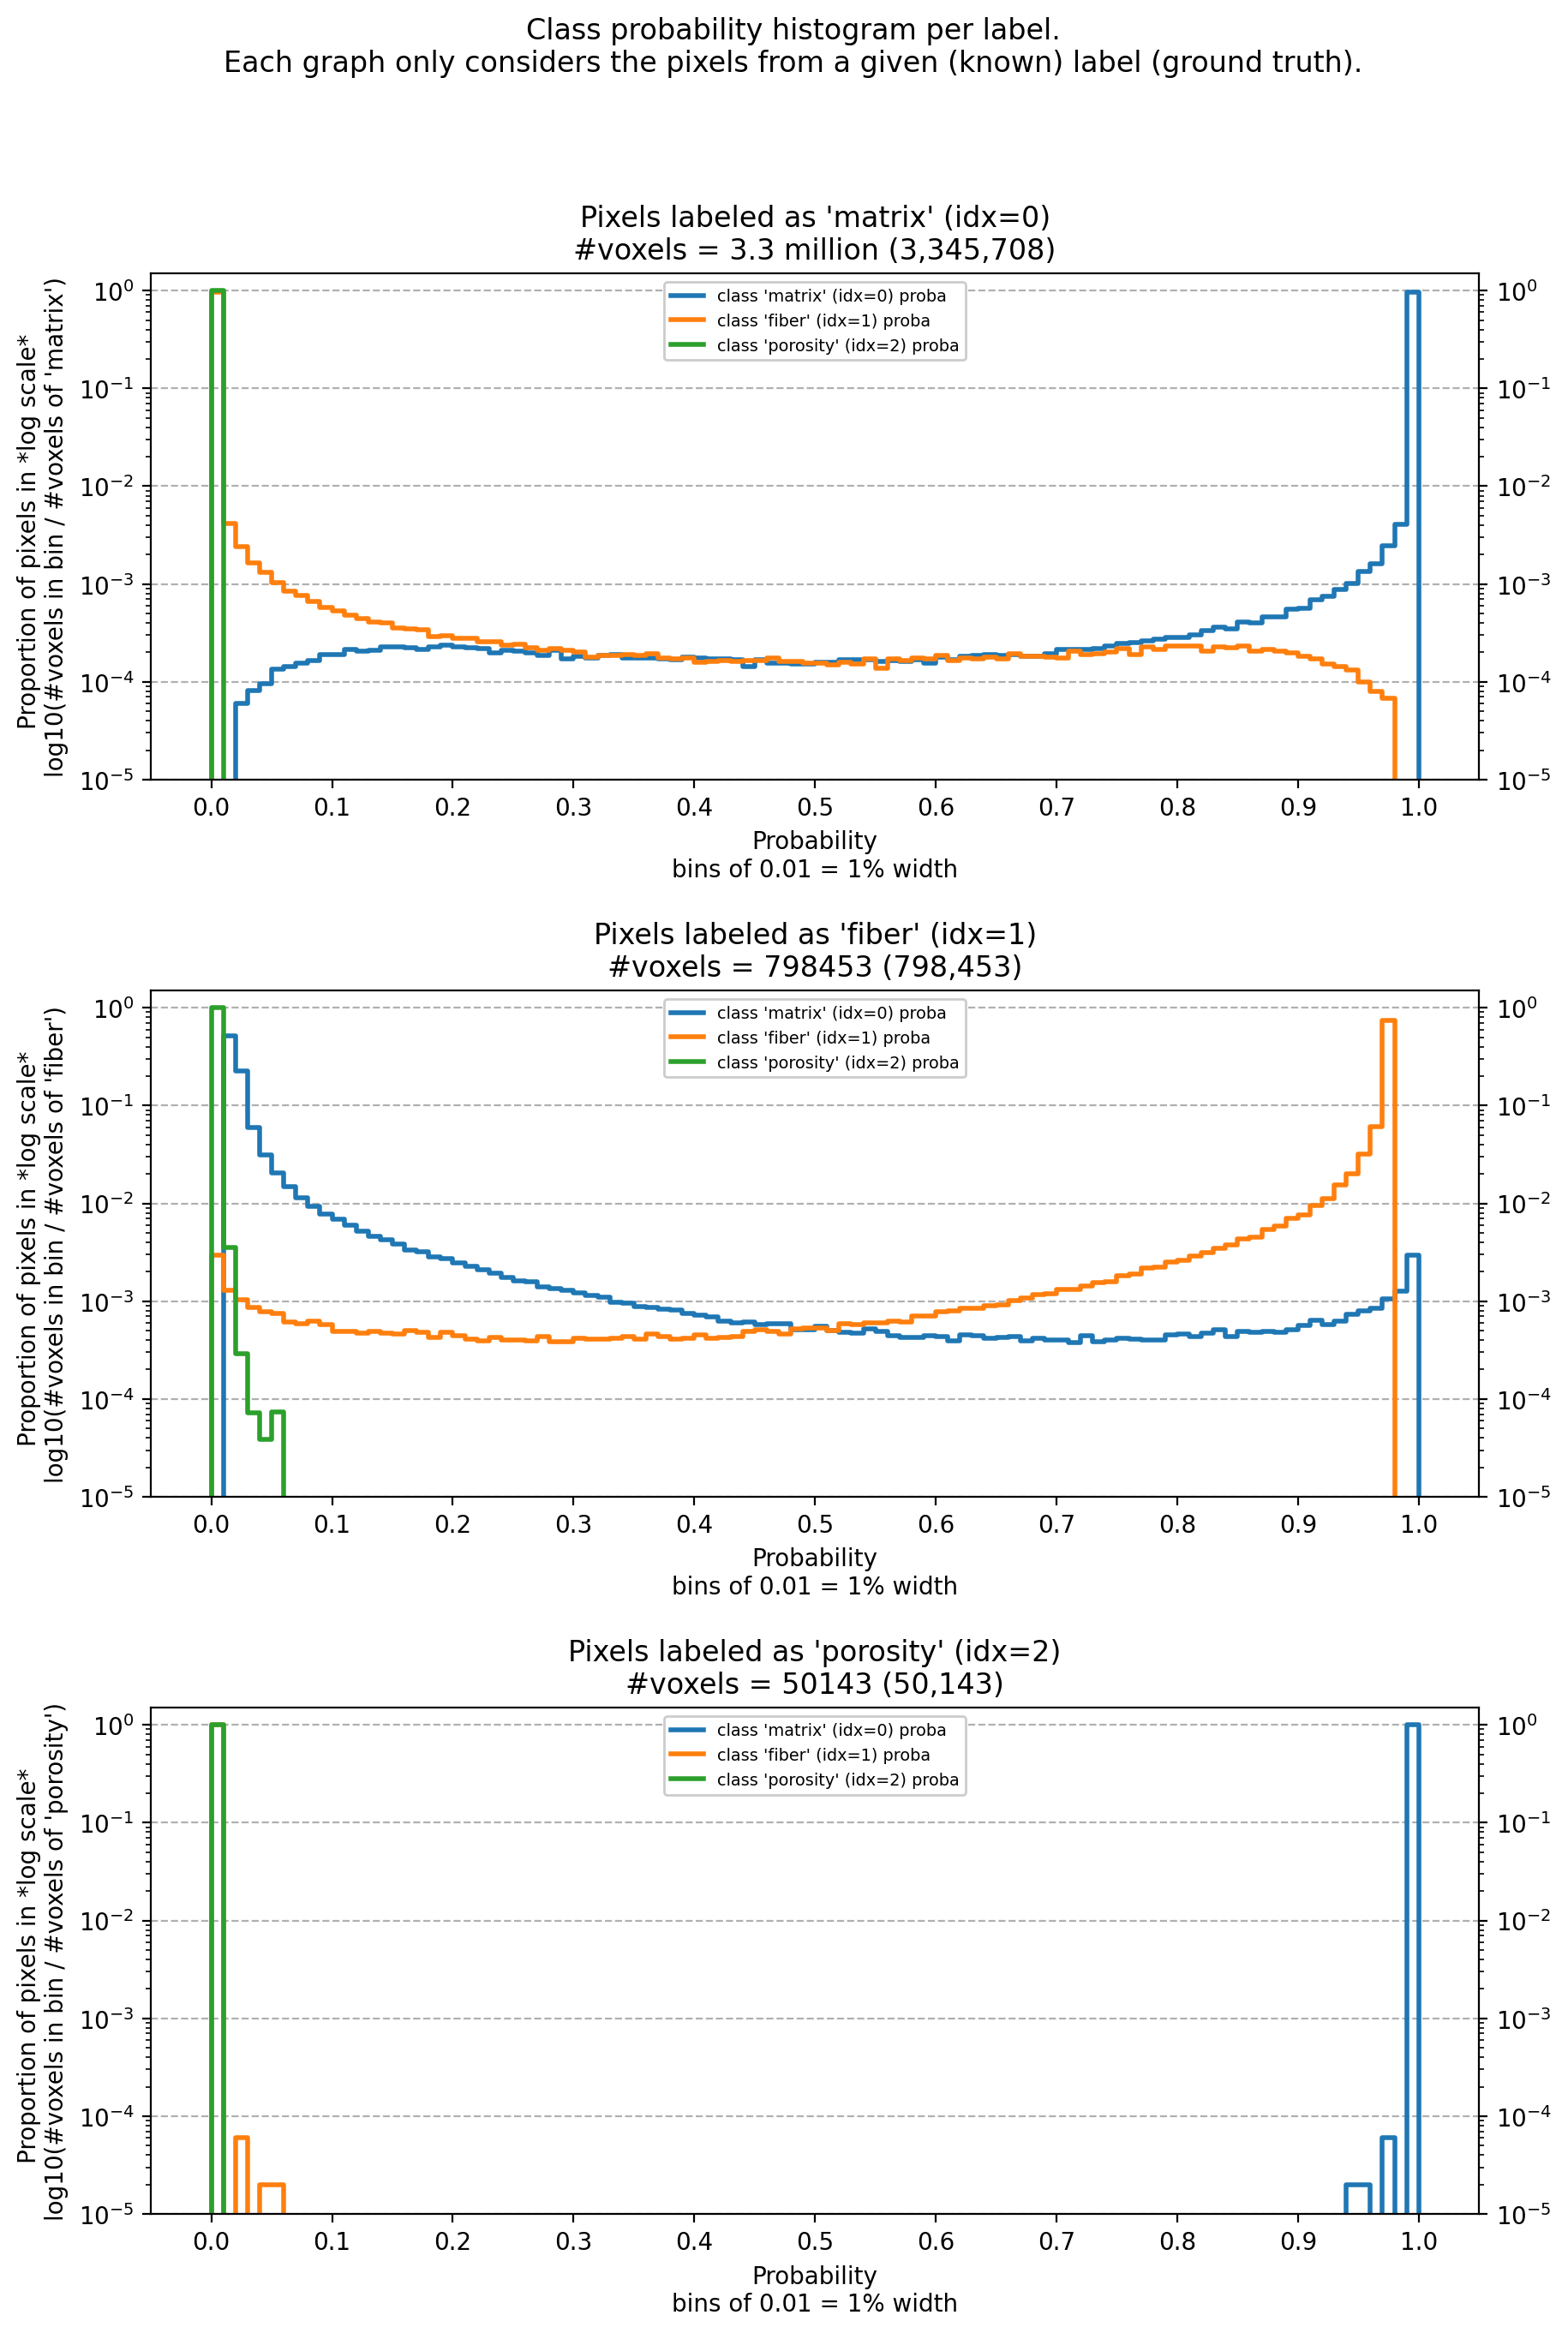

In [37]:
logger.info(f"Saving figure {(fig_name := 'class-probabilities-per-label.png')=}")

fig, axs = plt.subplots(
    3, 1, figsize=(2 * (sz := 5), 3 * sz), dpi=(dpi := 200),
    gridspec_kw=dict(wspace=0, hspace=sz/12)
)
xlims = (-.05, 1.05)
ylims_10pow = (-5, 0)
ylims = tuple(10 ** p for p in ylims_10pow)

for label_idx, ax in zip(labels_idx, axs.ravel()):
    logger.debug(f"Plotting histograms for {label_idx=}")
    
    
#             f"#voxels = {humanize.intword(label_n_voxels := labels_counts[label_idx])} "
#             f"({humanize.intcomma(label_n_voxels)})"
    ax.legend(loc="upper center", fontsize="x-small", framealpha=1)

fig.suptitle(
    "Class probability histogram per label."
    "\nEach graph only considers the pixels from a given (known) label (ground truth)."
)
    
fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

# Prediction normalized entropy

In [ ]:
eps = 1e-18
max_entropy = - np.log(1 / (n_classes + eps))

In [ ]:
logger.info("Computing voxels' probability distribution normalized entropies.")
normalized_voxel_entropies = - (probas_volume * np.log(probas_volume + eps)).sum(axis=-1) / max_entropy

In [ ]:
logger.debug(f"{normalized_voxel_entropies.shape=}")

In [ ]:
logger.info(f"Saving normalized entropies volume to {(str_path := str(estimation_volume.voxel_normalized_entropy_path))=}")
file_utils.HST_write(normalized_voxel_entropies.astype(np.float32), str_path)

In [ ]:
logger.debug("Computing entropy histograms per label.")

entropy_histograms = []

bins = np.linspace(0, 1, 101)

for label_idx in labels_idx:
    logger.debug(f"Computing histogram for {label_idx=}")
    
    selector = labels_volume == label_idx
    values, _ = np.histogram(
        normalized_voxel_entropies[selector].ravel(), 
        bins=bins
    ) 
    entropy_histograms.append(values / values.sum())
    
entropy_histograms = np.array(entropy_histograms)

In [ ]:
logger.info(f"Saving normalized entropy histograms at `{estimation_volume.voxel_normalized_entropy_histograms_path=}`")
np.save(
    estimation_volume.voxel_normalized_entropy_histograms_path,
    entropy_histograms
)

In [ ]:
logger.debug(f"Saving figure {(fig_name := 'normalized-entropy-histogram-per-label.png')=}")

fig, ax = plt.subplots(
    1, 1, figsize=(2 * (sz := 6), sz), dpi=(dpi := 200),
)
xlims = (-.05, 1.05)
ylims_10pow = (-5, 0)
ylims = tuple(10 ** p for p in ylims_10pow)

for label_idx in labels_idx:
    logger.debug(f"Plotting histogram for {label_idx=}")
    
    ax.step(
        np.concatenate([bins, [1.001]]),
        np.concatenate([[0], entropy_histograms[label_idx], [0]]),
        label=f"voxels '{labels_names[label_idx]}' (idx={label_idx}) (#voxels: {humanize.intcomma(labels_counts[label_idx])})",
        linewidth=1.5
    )
    
    ax.set_yscale('log')
    ax.set_ylim(ylims[0], 1.5 * ylims[1])
    ax.set_yticks(np.logspace(ylims_10pow[0], ylims_10pow[1], ylims_10pow[1] - ylims_10pow[0] + 1))
    ax.set_ylabel(
        f"Proportion of voxels in *log scale* \n"
        f"log10(#voxels in bin / #voxels of '{(label_name := labels_names[label_idx])}')"
    )
    
    ax.set_xlim(*xlims)
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.set_xlabel("Normalized entropy\nbins of 0.01 = 1% width")

    ax.tick_params(axis='y', left=True, right=True, labelleft=True, labelright=True, which="both")    
    ax.grid(True, axis='y', which='major', ls='--')    
    
    ax.set_title(
        f"Normalized entropy (NE) histogram\n"
        f"NE = - (SUM_i P[x_i] * log(P[x_i])) / MAX_NE" 
    )
    ax.legend(loc="upper center", fontsize="small", framealpha=1)

fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

# Probabilities plane (2D)

It is possible to visualize the probabilities on a plane because 

$$\sum_{i = 1}^{n\_classes} p_i = 1$$

So, when $n\_classes = 3$, we actually have 2 degrees of freedom. 

In [ ]:
import matplotlib

In [ ]:
%%time

logger.info(
    f"Saving figure of probabilities scattered on a plane {(fig_name := f'probabilities-scatter.png')=}"
)

fig, ax = plt.subplots(
    n_rows := 1, 
    n_cols := 1, 
    figsize=(n_cols * (sz := 16), n_rows * sz), 
    dpi=(dpi := 150),
)

x_label, y_label, z_label = labels_idx

logger.debug(f"{(x_label, y_label, z_label)=}")

colors = ['r', 'g', 'b']
argmax_points = [
    xmax_points := np.array([[.5, 0], [1, 0], [.5, .5], [1./3, 1./3]]),
    ymax_points := np.vstack([xmax_points[:, 1], xmax_points[:, 0]]).T,
    zmax_points := np.array([[0, 0], [0, .5], [1./3, 1./3], [.5, 0]]),
]

for points, c in zip(argmax_points, colors):
    ax.add_patch(matplotlib.patches.Polygon(points, color=c, alpha=.1))

n_per_label = int(1e4)
logger.debug(f"{n_per_label=}")

ax.set_xlim(0, 1 + (margin := .00))
ax.set_ylim(0, 1 + margin)

ticks = np.linspace(0, 1, 11)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_title(
    f"Voxel probabilities scatter with {humanize.intcomma(n_per_label)} voxels per label\n"
    "background colors indicate the class of max probability",
    fontsize='x-large'
) 
ax.set_xlabel(f"Probability of '{labels_names[x_label]}' (idx={x_label})", fontsize='x-large')
ax.set_ylabel(f"Probability of '{labels_names[y_label]}' (idx={y_label})", fontsize='x-large')

for third_proba in ticks[1:-1]:
    ax.plot([0, third_proba], [third_proba, 0], c='gray', ls='-.', linewidth=.35)
    ax.text(third_proba / 2, third_proba / 2, f"{1. - third_proba:.1f}", c='gray', rotation=-45, rotation_mode='anchor', fontsize='small')
ax.plot([0, 1], [1, 0], c='k', ls='--', linewidth=.75)
ax.text((p := .4) + .01, 1 - p, f"Probability of '{labels_names[z_label]}' (idx={z_label}) = 0.0", c='k', rotation=-44.5, rotation_mode='anchor', fontsize='x-large')

for label_idx, c, label_name in zip(labels_idx, colors, labels_names):
    logger.debug(f"{label_idx=}")
    sample = probas_volume_reshaped[labels_volume.ravel() == label_idx, :]
    idx = random_state.choice(
        np.arange(0, len(sample)), size=n_per_label, replace=False
    )
    sample = sample[idx, :]
    logger.debug(f"{label_idx=}  {len(sample)=}")
    ax.scatter(
        sample[:, x_label], sample[:, y_label],
        c=c, marker='.', label=label_name
    )
    
ax.legend(loc='upper right', fontsize='xx-large')

fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

In [ ]:
del probas_volume_reshaped

# Pixel-wise metrics

## Classification report

In [ ]:
classification_report_func = functools.partial(
    metrics.classification_report,
    # options
    labels=labels_idx,
    target_names=labels_names,
    sample_weight=None,
    output_dict=True,
    zero_division="warn",
)

In [ ]:
%%time
logger.info("Computing classification report")
classification_report = classification_report_func(
    labels_volume.ravel(), predictions_volume.ravel(),
)

### extra: jaccard

In [ ]:
jaccard_binary_func = functools.partial(
    metrics.jaccard_score, labels=labels_idx, average=None
)

jaccard_macro_func = functools.partial(
    metrics.jaccard_score, labels=labels_idx, average="macro",
)

jaccard_weighted_func = functools.partial(
    metrics.jaccard_score, labels=labels_idx, average="weighted",
)

In [ ]:
logger.info("Computing jaccard score.")

logger.debug("Computing jaccard score per label.")
bin_jacc = jaccard_binary_func(labels_volume.ravel(), predictions_volume.ravel())

for label_idx, label_name in zip(labels_idx, labels_names):
    classification_report[label_name]["jaccard"] = float(bin_jacc[label_idx])
    
logger.debug("Computing jaccard score averages.")
classification_report["macro avg"]["jaccard"] = float(
    jaccard_macro_func(labels_volume.ravel(), predictions_volume.ravel())
)
classification_report["weighted avg"]["jaccard"] = float(
    jaccard_weighted_func(labels_volume.ravel(), predictions_volume.ravel())
)

### extra: Normalized Discounted Cumulative Gain (ndcg)

In [ ]:
%%time

if probabilities_are_available:
    logger.info("Probabilities are availabe, computing NDCG")

    ohe = preprocessing.OneHotEncoder(
        categories=[labels_idx], dtype=np.int8, handle_unknown="error"
    )

    # even if categories are given, fit() still has to be called
    ohe.fit(np.array(labels_idx).reshape(-1, 1))
    
    # computing with everthing will take too long
    logger.debug(f"{(ndcg_n_samples := 10**6)=}")
    
    logger.debug(f"Sampling voxels {ndcg_n_samples=}")
    ndcg_indices = random_state.choice(
        np.arange(0, n_voxels), replace=False, size=ndcg_n_samples
    )

    ndcg_labels = labels_volume.ravel()[ndcg_indices]
    ndcg_probas = probas_volume.reshape(-1, n_classes)[ndcg_indices, :]
    
    logger.debug(f"Number of pixels of each class: {dict(Counter(ndcg_labels))}")    
    
    logger.info(f"Computing ndcg score")
    classification_report["ndcg"] = float(metrics.ndcg_score(
        ohe.transform(ndcg_labels.reshape(-1, 1)).toarray(), ndcg_probas
    ))

### Save

In [ ]:
class HumanizedDumper(yaml.Dumper):
    pass
   

def percentage_float_representer(dumper, value):
    return dumper.represent_scalar(u'tag:yaml.org,2002:str', f"{value:.2%}")


def humanize_int_representer(dumper, value):
    return dumper.represent_scalar(u'tag:yaml.org,2002:str', f"{humanize.intword(value)} ({humanize.intcomma(value)})")


HumanizedDumper.add_representer(float, percentage_float_representer)
HumanizedDumper.add_representer(int, humanize_int_representer)

In [ ]:
yaml_dump_classification_report = functools.partial(
    yaml.dump,
    default_flow_style=False, 
    indent=4, 
    sort_keys=False
)

In [ ]:
logger.info(
    f"Saving exact and humanized classification report to (respectively):"
    f"\n{estimation_volume.pixelwise_classification_report_exact}"
    f"\n{estimation_volume.pixelwise_classification_report_human}"
)

with estimation_volume.pixelwise_classification_report_exact.open('w') as f:
    yaml_dump_classification_report(classification_report, f)

with estimation_volume.pixelwise_classification_report_human.open('w') as f:
    report_str = yaml_dump_classification_report(classification_report, Dumper=HumanizedDumper)
    f.write(report_str)

In [ ]:
print(report_str)

In [ ]:
with estimation_volume.pixelwise_classification_report_exact.open() as f:
# with estimation_volume.pixelwise_classification_report_human.open() as f:
    classification_report = yaml.load(f, Loader=yaml.Loader)

In [ ]:
table = []
cols = sorted(classification_report['macro avg'].keys())
idx = []
# table.append([''] + headers)

for key, val in classification_report.items():
    if type(val) != dict:
        continue
    idx.append(key)
    table.append([
        val[dic_key]
        for dic_key in headers
    ])
                

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(table, columns=headers, index=idx)

In [ ]:
df[['support', 'precision', 'recall']]

In [ ]:
df[['support', 'f1-score']]

In [ ]:
df[['support', 'jaccard']]

## Confusion matrix

In [ ]:
%%time

logger.info("Computing confusion matrix.")

# doing it in batches to fit my pc memory...
n_batches = 30
batch_indices = np.linspace(0, n_voxels, n_batches + 1).astype(int)

confusion_matrix = np.zeros((n_classes, n_classes))

for s, e in pbar(zip(batch_indices[:-1], batch_indices[1:]), max_value=n_batches):
    confusion_matrix += metrics.confusion_matrix(
        # data
        labels_volume.ravel()[s:e], predictions_volume.ravel()[s:e],
        # options
        labels=volume.metadata.labels,
        sample_weight=None,
    )

In [ ]:
logger.info(f"Saving confusion matrix to {estimation_volume.confusion_matrix_path=}.")

np.save(
    estimation_volume.confusion_matrix_path,
    confusion_matrix
)

In [ ]:
logger.debug(f"Saving figure {(fig_name := 'confusion-matrix.png')=}")

fig, axs = plt.subplots(
    n_rows := 1, 
    n_cols := 3, 
    figsize=(n_cols * (sz := 7), n_rows * sz), 
    dpi=(dpi := 120),
    gridspec_kw=dict(wspace=sz/30),
)

cm_display = metrics.ConfusionMatrixDisplay(
    cm_normalized := confusion_matrix / confusion_matrix.sum(), 
    display_labels=labels_names,
)
cm_display.plot(values_format='.3%', cmap=cm.inferno, ax=axs[0])
cm_display.ax_.set_title("Confusion matrix normalized (%)")

cm_display = metrics.ConfusionMatrixDisplay(
    cm_true_label_normalized := confusion_matrix / confusion_matrix.sum(axis=1).reshape(-1, 1), 
    display_labels=labels_names,
)
cm_display.plot(values_format='.1%', cmap=cm.inferno, ax=axs[1])
cm_display.ax_.set_title("Confusion matrix normalized (%)\nby *true label* (by line)")

cm_display = metrics.ConfusionMatrixDisplay(
    cm_predicted_label_normalized := confusion_matrix / confusion_matrix.sum(axis=0).reshape(1, -1), 
    display_labels=labels_names,
)
cm_display.plot(values_format='.1%', cmap=cm.inferno, ax=axs[2])
cm_display.ax_.set_title("Confusion matrix normalized (%)\nby *predicted label* (by column)")

fig.suptitle("Global confusion matrix")

fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

## Binary confusion matrices

In [ ]:
logger.info("Computing binary confusion matrices (per label).")

binary_confusion_matrices = []

for label_idx in range(n_classes):
    tp = confusion_matrix[label_idx, label_idx]
    fn = confusion_matrix[label_idx, :].sum() - tp
    fp = confusion_matrix[:, label_idx].sum() - tp
    tn = confusion_matrix.sum() - fp - fn - tp
    binary_confusion_matrices.append([
        [tn, fp],
        [fn, tp],
    ])
    
binary_confusion_matrices = np.array(binary_confusion_matrices)

logger.debug(f"{binary_confusion_matrices.shape=}")

In [ ]:
logger.info(f"Saving binary confusion matrices to {estimation_volume.binary_confusion_matrices_path}.")
np.save(
    estimation_volume.binary_confusion_matrices_path,
    binary_confusion_matrices
)

In [ ]:
logger.info(
    f"Saving figure of binary confusion matrices at "
    f"{(fig_name := f'binary-confusion-matrices.png')=}"
)

fig, axs = plt.subplots(
    n_rows := 2, 
    n_cols := n_classes, 
    figsize=(n_cols * (sz := 6), n_rows * sz), 
    dpi=(dpi := 120),
    gridspec_kw=dict(wspace=sz/20, hspace=sz/20),
)

for label_idx, ax in zip(labels_idx, axs[0].ravel()):
    logger.debug(f"Drawing CM of class {label_idx=} (1st line)")
    confmat = binary_confusion_matrices[label_idx]
    
    cm_display = metrics.ConfusionMatrixDisplay(
        confmat / confmat.sum(axis=1).reshape(-1, 1), 
        display_labels=[f"non-{(label_name := labels_names[label_idx])}", label_name],
    )
    cm_display.plot(values_format='.1%', cmap=cm.inferno, ax=ax)
    cm_display.ax_.set_title(
        f"Binary CM normalized by line (%)\n"
        f"class `{label_name}` (idx={label_idx})"
    )

for label_idx, ax in zip(labels_idx, axs[1].ravel()):
    logger.debug(f"Drawing CM of class {label_idx=} (2nd line)")
    confmat = binary_confusion_matrices[label_idx]
    
    cm_display = metrics.ConfusionMatrixDisplay(
        confmat / confmat.sum(axis=0).reshape(1, -1), 
        display_labels=[f"non-{(label_name := labels_names[label_idx])}", label_name],
    )
    cm_display.plot(values_format='.1%', cmap=cm.inferno, ax=ax)
    cm_display.ax_.set_title(
        f"Binary CM normalized by column (%)\n"
        f"class `{label_name}` (idx={label_idx})"
    )


fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

## ROC curves

In [ ]:
logger.info("Computing ROC curves")

roc_curves = []

for label_idx in labels_idx:
    logger.debug(f"Computing roc curve of class idx={label_idx}")
    
    fpr, tpr, th = metrics.roc_curve(
        labels_volume.ravel(), probas_volume.reshape(-1, n_classes)[:, label_idx], 
        pos_label=label_idx,
        drop_intermediate=True
    )
    roc_curves.append((
        label_roc_curve := np.array([fpr, tpr, th])
    ))
    
    logger.debug(
        f"Saving roc curve of class idx={label_idx} "
        f"at {(roc_path := estimation_volume.get_class_roc_curve_path(label_idx))=}"
    )
    np.save(roc_path,label_roc_curve)

In [ ]:
logger.info(f"Saving figure of ROC curves at {(fig_name := f'roc-curves.png')}")

fig, axs = plt.subplots(
    n_rows := 1, 
    n_cols := 2, 
    figsize=(n_cols * (sz := 7), n_rows * sz), 
    dpi=(dpi := 130),
)

zoom = np.array(((0, .15), (.85, 1)))

fig.suptitle("Per class ROC curves")

ax_full, ax_zoom = axs[0], axs[1]
ax_full.set_title("Full curve range [0, 1] x [0, 1]")
ax_full.set_xlim(0, 1)
ax_full.set_ylim(0, 1)

ax_zoom.set_title(f"Zoom on [{zoom[0, 0]}, {zoom[0, 1]}] x [{zoom[1, 0]}, {zoom[1, 1]}]")
ax_zoom.set_xlim(*zoom[0])
ax_zoom.set_ylim(*zoom[1])

for label_idx, (fpr, tpr, _) in zip(labels_idx, roc_curves):
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{label_idx}")
    for ax in axs:
        roc_display.plot(ax=ax)  

max_label_name_length = max(*map(len, labels_names))

for label_idx, (fpr, tpr, _) in zip(labels_idx, roc_curves):
    ax_full.get_legend().texts[label_idx].set_text(
        f"class {(label_name := labels_names[label_idx])} (idx={label_idx})"
        f" (AUC={(roc_auc := metrics.auc(fpr, tpr)):.4%})"
    )
ax_zoom.legend_ = None
         
fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

# Confusion volume

In [ ]:
logger.info("Computing confusion volumes")

for label_idx in labels_idx:

    tp_volume = (labels_volume == label_idx) & (predictions_volume == label_idx)
    fn_volume = (labels_volume == label_idx) & (predictions_volume != label_idx)
    fp_volume = (labels_volume != label_idx) & (predictions_volume == label_idx)

    conf_vol = (
        np.zeros_like(labels_volume, dtype=(vol_dtype := np.uint8))
        + 50 * fn_volume.astype(vol_dtype)
        + 100 * fp_volume.astype(vol_dtype)
        + 255 * tp_volume.astype(vol_dtype)
    )
    
    logger.debug(
        f"Saving confusion volume for class {label_idx=} "
        f"at {(str_path := str(estimation_volume.get_confusion_volume_path(label_idx)))=}"
    )
    file_utils.HST_write(conf_vol, str_path)    

## 2D error blobs

## 3D error blobs

# Physical metrics

# Notable slices

In [ ]:
estimation_volume["lalala"] 